# Proprocessing of input data for Yield-gap analysis

Data sources:  
- EarthStat yield gap data [source](http://www.earthstat.org/yield-gaps-climate-bins-major-crops/)  


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr

module_path = Path.cwd().resolve()
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# calculate area grid for summary stats
def calc_area(lat, pixeldegree):
    area_km2 = (110.45 * pixeldegree) * (111.1944 * pixeldegree) * math.cos(lat * (math.pi / 180.0))
    area_ha  = area_km2 * 100
    return area_ha

def create_area_grid(da, res=0.1):
    da_area = xr.zeros_like(da)
    da_area.attrs = {'long_name': 'area', 'units': 'ha'}
    da_area.name = 'area'
    for lat in da_area.lat.values:
        da_area.loc[{'lat': lat}] = calc_area(lat, res)
    return da_area


def fix_coords(da, res=0.1):
    """Make sure that float32 and float64 have the exact same coordinates so we can compute with them"""
    ndigits = len(str(res).split('.')[-1])+1
    
    for y, x in [('latitude', 'longitude'),('lat', 'lon'), ('y', 'x')]:
        if (y in list(da.coords)) and (x in list(da.coords)):
            return da.assign_coords({y: da[y].astype('float32').round(ndigits), x: da[x].astype('float32').round(ndigits)})
    raise NotImplementedError

In [4]:
data_path = Path('data')

## Bioclimatic zones

Load the GeoTiff produced by resampling to 0.1x0.1deg in ArcGIS.

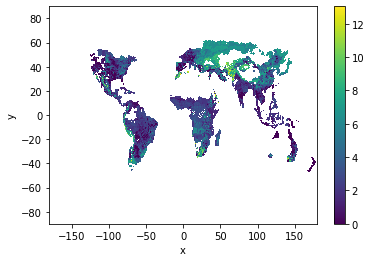

In [5]:
# load bioclimate data (import of resampled geotiff/ source: ArcGIS resampling)
ygap = xr.open_rasterio(data_path / "maize_yieldgap.tif").squeeze(drop=True)
ygap = fix_coords(ygap, res=0.083)
ygap = ygap.where(ygap > -1000)
ygap.plot();

In [6]:
ygap = ygap.rename({'x': 'lon', 'y': 'lat'})
ygap

<xarray.DataArray (lat: 2160, lon: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.9583 89.875 89.7917 ... -89.7917 -89.875 -89.9583
  * lon      (lon) float32 -179.9583 -179.875 -179.7917 ... 179.875 179.9583
Attributes:
    transform:      (0.0833333333333286, 0.0, -180.0, 0.0, -0.083333333333328...
    crs:            +init=epsg:4326
    res:            (0.0833333333333286, 0.0833333333333286)
    is_tiled:       1
    nodatavals:     (-3.402823e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [7]:
dsout = xr.Dataset()
dsout['yieldgap'] = ygap.astype('float32')

# sort latitude to go from net to pos
dsout = dsout.sortby(dsout.lat)
dsout.to_netcdf('yieldgap_maize.nc')

In [8]:
# load ygap again
ygap = xr.open_dataset("yieldgap_maize.nc")['yieldgap']
ygap = fix_coords(ygap, res=0.083)

In [9]:
ygap

<xarray.DataArray 'yieldgap' (lat: 2160, lon: 4320)>
[9331200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.9583 -89.875 -89.7917 ... 89.7917 89.875 89.9583
  * lon      (lon) float32 -179.9583 -179.875 -179.7917 ... 179.875 179.9583

In [10]:
ygap = ygap.sel(lat=slice(-50,40), lon=slice(-30, 60))

In [18]:
tm2 = xr.open_dataset(data_path / 'tmworld' / 'tmworld_un_HR.nc').sel(lat=slice(-50,40), lon=slice(-30, 60))
admin2 = fix_coords(tm2, res=0.083)
admin2 = admin2.rename({'Band1': 'COUNTRY'})
admin2.to_netcdf('countries_0083deg.nc')

# Create mask dataset

In [11]:
# africa/ sub-sahara masks
# codes can be obtained from the lut files in data/tmworld
tm1 = xr.open_dataset(data_path / 'tmworld' / 'tmworld_region_HR.nc').sel(lat=slice(-50,40), lon=slice(-30, 60))
admin = fix_coords(tm1, res=0.083)
admin = admin.rename({'Band1': 'REGION'})

africa = admin.REGION.where(admin.REGION == 2).notnull()

mask = africa.to_dataset()
mask.to_netcdf('africa_mask_0083deg.nc')

In [12]:
tm1

<xarray.Dataset>
Dimensions:  (lat: 1080, lon: 1080)
Coordinates:
  * lat      (lat) float64 -49.96 -49.87 -49.79 -49.71 ... 39.79 39.88 39.96
  * lon      (lon) float64 -29.96 -29.88 -29.79 -29.71 ... 59.79 59.87 59.96
Data variables:
    Band1    (lat, lon) float64 ...
    crs      |S1 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 1.11.3, released 2015/09/16
    history:      Wed May 18 07:30:00 2016: GDAL Create( tmworld_region_HR.nc...

In [13]:
africa

<xarray.DataArray 'REGION' (lat: 1080, lon: 1080)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float32 -49.9583 -49.875 -49.7917 ... 39.7917 39.875 39.9583
  * lon      (lon) float32 -29.9583 -29.875 -29.7917 ... 59.7917 59.875 59.9583

In [14]:
ygap

<xarray.DataArray 'yieldgap' (lat: 1080, lon: 1080)>
[1166400 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -49.9583 -49.875 -49.7917 ... 39.7917 39.875 39.9583
  * lon      (lon) float32 -29.9583 -29.875 -29.7917 ... 59.7917 59.875 59.9583

# Create area grid

In [20]:
with xr.Dataset() as new:
    new["ygap"] = ygap
    new["mask"] = mask.REGION
    new["ygapm"] = ygap.where(africa == True)
    new["area"] = create_area_grid(ygap, res=0.0833333333)
    new.to_netcdf("yieldgap_maize_0083deg.nc")

In [21]:
def read_asc(fname):
    SIZE = 0.083333333333
    HSIZE =  SIZE * 0.5
    
    with open(fname, 'r') as f:
        lines = f.read().splitlines()
    data = np.array([[int(x) for x in line.split()] for line in lines[5:]]).astype('float')
    lats = np.arange(-35 + HSIZE, -35 + (876*SIZE), SIZE)[::-1]
    lons = np.arange(-18 + HSIZE, -18 + (840*SIZE), SIZE)
    da = xr.DataArray(np.zeros((876, 840), 'float'), coords=[('lat', lats),('lon', lons)], name='rotations')
    data[data==14] = np.nan 
    da[:] = data - 1
    return da

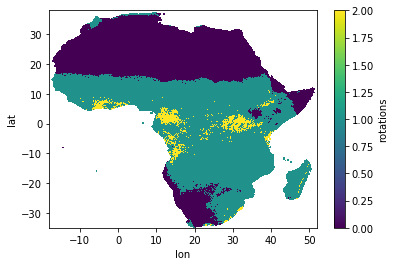

In [22]:
da = read_asc("data/n_seasons_africa_5m.asc")
da.plot()

In [23]:
da = da.sortby(da.lat)

In [24]:
da2 = da.reindex_like(new.area, method='nearest', tolerance=0.01)
da2

<xarray.DataArray 'rotations' (lat: 1080, lon: 1080)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -49.96 -49.88 -49.79 -49.71 ... 39.79 39.88 39.96
  * lon      (lon) float64 -29.96 -29.88 -29.79 -29.71 ... 59.79 59.88 59.96

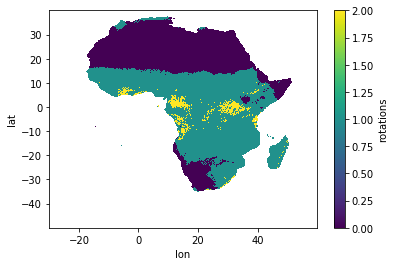

In [25]:
da2.plot()

In [26]:
da.lat

<xarray.DataArray 'lat' (lat: 876)>
array([-34.958333, -34.875   , -34.791667, ...,  37.791667,  37.875   ,
        37.958333])
Coordinates:
  * lat      (lat) float64 -34.96 -34.88 -34.79 -34.71 ... 37.79 37.87 37.96

In [31]:
with xr.Dataset() as new:
    new["ygap"] = ygap
    new["mask"] = mask.REGION
    new["ygapm"] = ygap.where(africa == True)
    new["area"] = create_area_grid(ygap, res=0.0833333333)
    new["rot"] = da2
    new["country"] = admin2.COUNTRY.where(africa == True)
    new.to_netcdf("yieldgap_maize_0083deg_v2.nc")

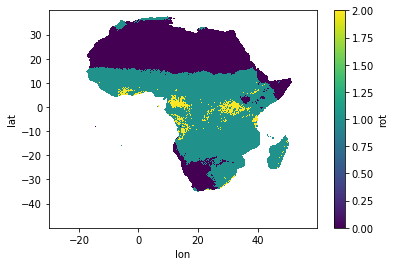

In [92]:
new.rot.plot()

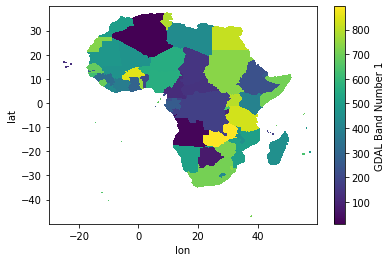

In [32]:
new.country.plot()